<a href="https://colab.research.google.com/github/atoothman/croton-cholera-analysis/blob/main/notebooks/04_1849_kmeans_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 04: KMeans Clustering Analysis (1849)

## Project: Croton Cholera Ward-Level Analysis

**Purpose**

Conduct an exploratory clustering analysis to identify structural typologies for New York City wards in 1849 based on population density, sewer infrastructure, Croton water distribution intensity (hydrant density), and cellar exposure.

**Goal**

To examine is ward characterized by similar infrastructural intensity and crowding conditions form distinct structural groupings, and to assess if cholera mortality patterns vary systematically across groupings.

Unsupervised KMeans clustering is applied to standardized structural variabels. Choelra mortality rates are not included in cluster formation but are compared across cluster to evaluate spatial patterning.

**Data**

Two clustering models:
* Model 1 (N = 18 wards): Population density, sewer density, cellar exposure
* Model 2 (N = 16 wards): Population density, sewer density, hydrant density, cellar exposure

Wards with incomplete hydrant data (16th & 18th Wards) are excluded only from Model 2.


# Environment Setup
Import libraries, clone repo, import dataset

In [64]:
# Import Libraries
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

import os

In [65]:
# Clone repo into colab
!git clone https://github.com/atoothman/croton-cholera-analysis.git

fatal: destination path 'croton-cholera-analysis' already exists and is not an empty directory.


In [66]:
# Define base path to cloned repository
base_path = "/content/croton-cholera-analysis"
data_path = os.path.join(base_path, "data")

# Load ward-level dataset
df = pd.read_csv(os.path.join(data_path, "ward_level_data.csv"))

# Confirm dataset shape
print("Initial dataset shape:", df.shape)

Initial dataset shape: (19, 29)


# Model 1

## Defining the 1849 Clustering Sample N = 18

The sections defined the full 1849 ward sample using population density, sewer density, and cellar exposure. Hydrant density is excluded to retain wards with incomplete hydrant data.

In [67]:
# Define structural variables for Model 1
model1_vars = [
    "pop_density_1850",
    "sewer_density_1847",
    "cellar_exposure_rate_1850"
]

# Create Model 1 dataset, drop ward 19
df_model1 = df[model1_vars + ["cholera_1849_rate_per_1000"]].dropna()

# Confirm sample size
print("Model 1 sample size:", df_model1.shape[0])

Model 1 sample size: 18


## Scaling Variables

This section standardizes structural predictors to ensure equal contribution to Euclidean distance in KMeans clustering.

In [68]:
# Initialize scaler
scaler = StandardScaler()

# Fit and transform structural variables
X1_scaled = scaler.fit_transform(df_model1[model1_vars])

# Convert back to DataFrame for inspection
X1_scaled_df = pd.DataFrame(
    X1_scaled,
    columns=model1_vars,
    index=df_model1.index
)

# Preview scaled data
X1_scaled_df.head()


,pop_density_1850,sewer_density_1847,cellar_exposure_rate_1850
0,-0.417579,1.115664,-0.443332
1,-0.896136,0.242536,-0.464434
2,-0.620369,1.115664,0.611103
3,1.610397,-0.630593,0.156598
4,-0.102525,1.115664,-0.840365


## Estimating KMeans Clustering

Estimates KMeans clustering solutions for k = 2 and K =3 to identify potential structural ward typologies.

In [69]:
# Estimate KMeans with K = 2
kmeans_k2 = KMeans(n_clusters=2, random_state=42, n_init=20)

df_model1["cluster_k2"] = kmeans_k2.fit_predict(X1_scaled)

# Evaluate separation quality
sil_k2 = silhouette_score(X1_scaled, df_model1["cluster_k2"])

print("Silhouette Score (K=2):", round(sil_k2, 3))


Silhouette Score (K=2): 0.438


Interpretation of K =2 Silhouette Score:

The K = 2 clustering returns a silhouette score of 0.438, indicating moderate structural seperation between ward groups. This suggest that the wards can be meaningfully partitioned into two distinct infrastructural typologies based on population density, sewer density, and cellar exposure.

In [70]:
# Estimate KMeans with K = 3
kmeans_k3 = KMeans(n_clusters=3, random_state=42, n_init=20)

df_model1["cluster_k3"] = kmeans_k3.fit_predict(X1_scaled)

# Evaluate separation quality
sil_k3 = silhouette_score(X1_scaled, df_model1["cluster_k3"])

print("Silhouette Score (K=3):", round(sil_k3, 3))

Silhouette Score (K=3): 0.43


Interpretation of K = 3 Silhouette Score:

The K = 3 returns a silhouette score of 0.430, which does not meaninfully improve separation from K = 2. Given the small sample size and comparable separation quality, K = 2 is retained.

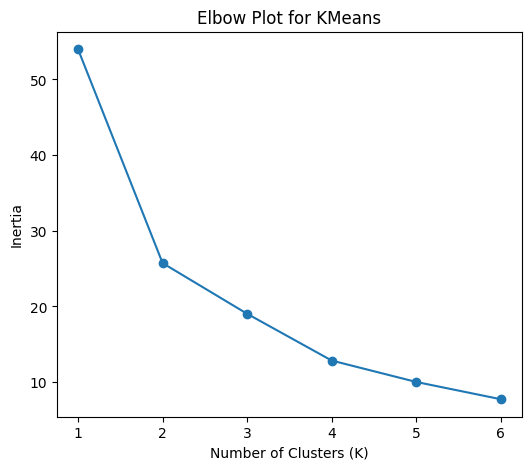

In [78]:
# Create Elbow Plot for KMeans to confirm K = 2 is the best option
inertia_values = []

# Ddefine the rang of clusters from K = 1 to K = 6
K_range = range(1, 7)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
    kmeans.fit(X1_scaled)
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(6,5))
plt.plot(K_range, inertia_values, marker="o")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Plot for KMeans")
plt.show()

Interpretation of Elbow Plot:

The elbow plot shows a sharp decline in inertia from K = 1 to K = 2, followed by a more gradual decrease for higher values of K. This pattern suggests that the largest structural improvement occurs when moving from a single cluster to a two-cluster solution.

 The Elbow Plot combined with the silhouette score of 0.438 for K = 2 supports the selection of a two-cluster model.


## Cluster-Level Structural and Cholera Summary (K = 2)

This section compares average structural characteristics and 1849 cholera mortality across the two identified ward clusters.

In [71]:
cluster_summary_m1 = df_model1.groupby("cluster_k2")[
    model1_vars + ["cholera_1849_rate_per_1000"]
].mean()

cluster_summary_m1

,pop_density_1850,sewer_density_1847,cellar_exposure_rate_1850,cholera_1849_rate_per_1000
cluster_k2,,,,
0,140218.956368,1.000000,0.04682,12.046050
1,58924.940720,2.444444,0.02593,7.906533


Interpretation of K = 2 Cluster:

Cluster 0
* Significantly higher population density
* Lower sewer infrastructure
* Slightly higher cellar exposure
* Higher cholera mortality

Cluster 1
* Lower population density
* Substantially higher sewer coverage
* Lower cellar exposure
* Lower cholera mortality

The two cluster solution reveals a clear structural gradient. Cluster 0 is characterized by substantially higher population density, lower sewer infrastructure intensity, and higher cholera mortality rates. Cluster 1 exhibits lower density, stronger sewer coverage, and lower cholera mortality. These results suggest that 1849 cholera severity patterned along infrastructural and crowding gradients at the ward level.

In [72]:
# Examine which wards are in each cluster
df_model1[["cluster_k2"]]

,cluster_k2
0,1
1,1
2,1
3,0
4,1
5,0
6,0
7,0
8,0
9,0


Interpertation of wards by cluster:

Cluster 0:
* High populaiton density
* Lower sewer density
* Slightly higher cellar density
* Higher cholera

Wards: 4th, 6th, 7th, 8th, 9th, 10th, 11th, 13th, 14th

Cluster 1:
* Lower population density
* Higher sewer density
* Slightly lower cellar density
* Lower cholera

Wards: 1st, 2nd, 3rd, 5th, 12th, 15th, 16th, 17th, 18th

The two cluster solution reveals a density infrastructure gradient across wards. Cluster 0 contains hier denisty wards with weaker sewer coverage and elevated choelra mortality. Cluster 1 contains lower density wards with stronger sewer infrastructure and lower mortality rates. Notably, Ward 16 does not cluster in the structurally vulnerable group despite its high cholera mortality rate per 1000.

In [73]:
# Examine ward by cluster and highest cholera rate
# Add ward_id for reporting only (does NOT affect clustering)
df_model1_with_id = df.loc[df_model1.index, ["ward_id"]].copy()
df_model1_with_id["cluster_k2"] = df_model1["cluster_k2"].values
df_model1_with_id["cholera_1849_rate_per_1000"] = df_model1["cholera_1849_rate_per_1000"].values

df_model1_with_id.sort_values("cholera_1849_rate_per_1000", ascending=False)

,ward_id,cluster_k2,cholera_1849_rate_per_1000
5,6,0,35.630415
3,4,0,28.989247
11,12,1,14.926801
15,16,1,14.712000
1,2,1,13.072878
12,13,0,11.470651
2,3,1,7.822308
6,7,0,7.800551
4,5,1,7.273208
9,10,0,6.647796


Interpretation of ward by cluster and cholera mortality rate:

The two highest mortality wards are Ward 6 and 4, both falling within Cluster 0 which include high denisty and lower sewer coverage. This supports the interpretation that extreme cholera mortality was concentrated in structurally vulnerable wards.

However, several moderately high mortality wards, including Wards 12, 16 and 2, are in Cluster 1, suggesting that sewer infrastructure and lower density did not fully insulate wards from elevated cholera risk. This indicated a more complex spatial pattern.

The 12th Ward did not have any sewer infrastructure. KMeans clusters on all standardized varaibles simultaneously.

In [74]:
# Checking 12th ward sewer density
df.loc[df["ward_id"] == 12,
       ["ward_id",
        "pop_density_1850",
        "sewer_density_1847",
        "cellar_exposure_rate_1850"]]


,ward_id,pop_density_1850,sewer_density_1847,cellar_exposure_rate_1850
11,12,852.446982,0.0,0.024591


In [75]:
df_model1_with_id[df_model1_with_id["ward_id"] == 12]

,ward_id,cluster_k2,cholera_1849_rate_per_1000
11,12,1,14.926801


In [76]:
df_density_sorted = df_model1.sort_values("pop_density_1850", ascending=False)

df_density_sorted_with_id = df.loc[df_density_sorted.index, ["ward_id"]].copy()
df_density_sorted_with_id["pop_density_1850"] = df_density_sorted["pop_density_1850"].values
df_density_sorted_with_id["cluster_k2"] = df_density_sorted["cluster_k2"].values

df_density_sorted_with_id

,ward_id,pop_density_1850,cluster_k2
3,4,178846.153800,0
12,13,166152.941200,0
10,11,156278.571400,0
5,6,154362.500000,0
13,14,148211.764700,0
9,10,137152.941200,0
7,8,123614.285700,0
6,7,108966.666700,0
4,5,94525.000000,1
16,17,91179.166670,1


Interpretation of the 12th Wards structural positioning:

Although Ward 12 had no sewer infrastructure in 1847, its population density was substantially lower than the most densely populated wards. In the standardized clustering space, Ward 12 aligns more closely with lower density wards, explaining its assignment to Cluster 1 despite the absence of sewers. This indicates that population density plays a primary role in defining structural groupings, while sewer intensity contributes but does not independently determine cluster membership.

## PCA Visualization of K = 2

PCA is not required for cluster, but it is useful for visualizaing separation.
To visualize multidimensional cluster separation, principal component analysis is used to project the standardized feature space into two dimensions.


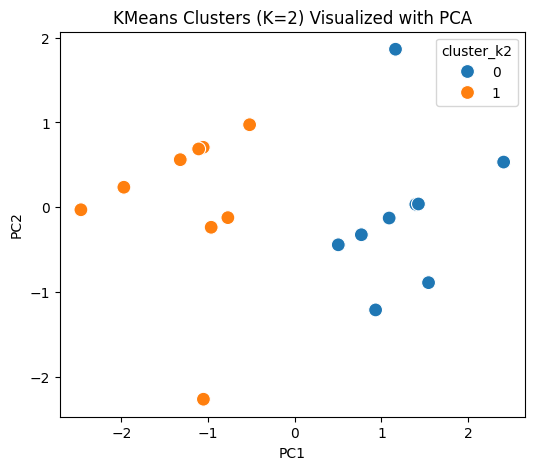

In [79]:
# Reduce standardized features to 2 components
pca = PCA(n_components=2)
X1_pca = pca.fit_transform(X1_scaled)

# Create visualization dataframe
pca_df = pd.DataFrame({
    "PC1": X1_pca[:, 0],
    "PC2": X1_pca[:, 1],
    "cluster_k2": df_model1["cluster_k2"].values
})

plt.figure(figsize=(6,5))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="cluster_k2", s=100)
plt.title("KMeans Clusters (K=2) Visualized with PCA")
plt.show()

Interpretation of K Means with PCA Scatterplot:

The scatterplots shows that the clusters are not overlapping.

## Cluster Separation in Original Variables

Cluster assignments are visualized directly in the original feature space to assess structural separation without dimensionality reduction.


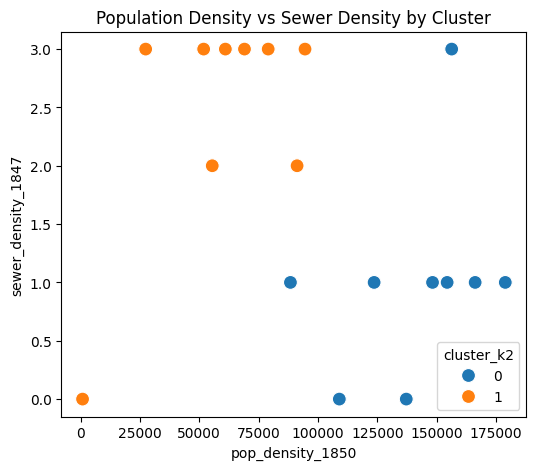

In [80]:
# Population Density vs Sewer Density

plt.figure(figsize=(6,5))
sns.scatterplot(
    data=df_model1,
    x="pop_density_1850",
    y="sewer_density_1847",
    hue="cluster_k2",
    s=100
)
plt.title("Population Density vs Sewer Density by Cluster")
plt.show()

Interpretation of Population Density vs Sewer Density by Cluster:

Cluster 0:
* High pop density
* low sewer density

Cluster 1:
* Low Pop density
* High sewer sensity


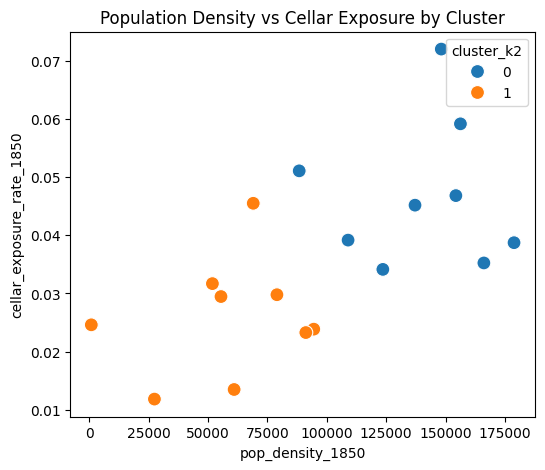

In [81]:
# Population Denisty vs Cellar Exposure
plt.figure(figsize=(6,5))
sns.scatterplot(
    data=df_model1,
    x="pop_density_1850",
    y="cellar_exposure_rate_1850",
    hue="cluster_k2",
    s=100
)
plt.title("Population Density vs Cellar Exposure by Cluster")
plt.show()

Interpretation of Population Density vs Cellar Exposure by Cluster:

Cluster 0:
* High pop density
* High cellar exposure

Cluster 1:
* Low pop density
* Low cellar exposure

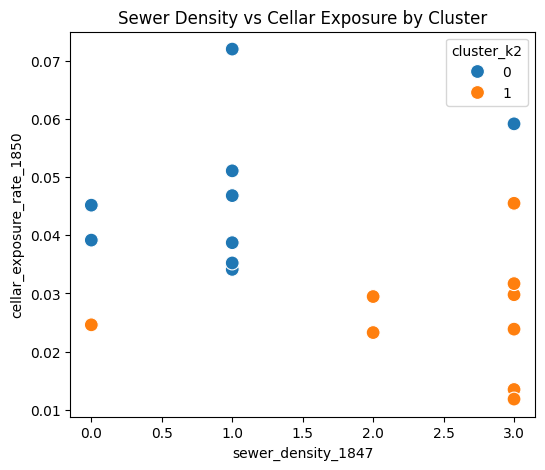

In [82]:
# Sewer Denisty vs Cellar Exposure
plt.figure(figsize=(6,5))
sns.scatterplot(
    data=df_model1,
    x="sewer_density_1847",
    y="cellar_exposure_rate_1850",
    hue="cluster_k2",
    s=100
)
plt.title("Sewer Density vs Cellar Exposure by Cluster")
plt.show()

Interpretation of Sewer Density vs Cellar Exposure by Cluster:

Cluster 0:
* Sewer density 0 -1
* High cellar exposure

Cluster 1:
* Sewer density 2 - 3
* Low cellar exposure

Wards with strong sewer networks tend to have lower cellar exposure.

Visualization Interpretation:

Visualization of the original structural variables confirm that the two cluster solution captures a clear infrastructural gradient across wards. Cluster 0 includes the most densely populated wards, which generally have lower sewer density and higher cellar exposure. Cluster 1 includes less densely populated wards with strong sewer infrastructure and lower cellar exposure. Separation is most pronounced along the population density axis, showing that crowding plays a dominate role in structuring ward level differences. These patterns support the interpretation that the clustering reflects a structural divide in the 1849 urban environment in New York City.

# Model 2

Variables:
* pop_density_1850
* sewer_density_1847
* hydrant_density_1849
* cellar_exposure_rate_1850

## Defining Clustering Sample N = 16

(N = 16)

N = 16 two wards (16th and 18th) are dropped due to lack of complete hydrant count available on cartography. Hydrant_density_1849 is introduced.

In [86]:
df.columns

Index(['ward_id', 'ward_name', 'population_1830', 'population_1850',
       'ward_area_1832', 'ward_area_1849', 'pop_density_1830',
       'pop_density_1850', 'cholera_1832_hotspot', 'cholera_1849_deaths',
       'cholera_1849_rate_per_1000', 'sewer_present_1838',
       'sewer_density_1838', 'sewer_present_1847', 'sewer_density_1847',
       'cellar_or_basement_count_1850', 'cellar_room_count_1850',
       'cellar_inhabitant_count_1850', 'persons_per_room_1850',
       'cellar_exposure_rate_1850', 'cellar_density_1850',
       'stopcock_count_1850', 'stopcock_density_1850', 'hydrant_count_1850',
       'hydrant_density_1850', 'stopcocks_per_sq_mile_1850',
       'hydrants_per_sq_mile_1850', 'stopcocks_per_1000_1850',
       'hydrants_per_1000_1850'],
      dtype='object')

In [89]:
# Select structural variables for Model 2
model2_vars = [
    "pop_density_1850",
    "sewer_density_1847",
    "hydrant_density_1850",
    "cellar_exposure_rate_1850"
]

# Drop rows with missing hydrant data, keep ward_id and cholera_1849_rate_per_1000 for later interpretation not used in clustering
df_model2 = df[model2_vars + ["ward_id", "cholera_1849_rate_per_1000"]].dropna().copy()

print("Model 2 sample size:", df_model2.shape[0])

Model 2 sample size: 16


## Scaling Variables

In [92]:
# Initialize scaler
scaler = StandardScaler()

# Fit and transform structural variables
X2_scaled = scaler.fit_transform(df_model2[model2_vars])

# Convert back to DataFrame for inspection
X2_scaled_df = pd.DataFrame(
    X2_scaled,
    columns=model2_vars,
    index=df_model2.index
)

# Preview scaled data
X2_scaled_df.head()

,pop_density_1850,sewer_density_1847,hydrant_density_1850,cellar_exposure_rate_1850
0,-0.597653,1.287753,1.21356,-0.585554
1,-1.099631,0.391925,0.13484,-0.607386
2,-0.810368,1.287753,0.13484,0.505366
3,1.529575,-0.503903,-0.94388,0.035135
4,-0.267180,1.287753,1.21356,-0.996324


## Estimating KMeans Clustering

Estimates KMeans clustering solutions for k = 2 and K =3 to identify potential structural ward typologies.

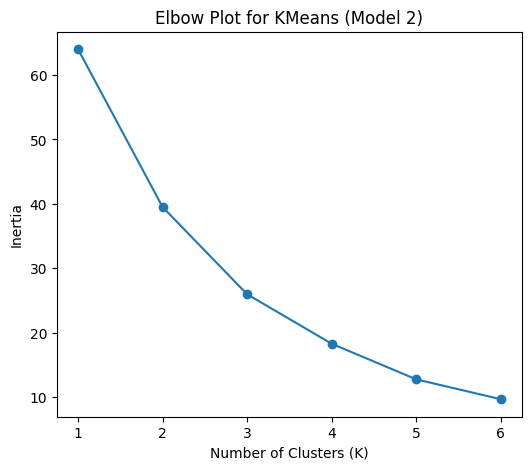

In [93]:
# Create Elbow Plot

inertia_values = []

# Define range of clusters
K_range = range(1, 7)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
    kmeans.fit(X2_scaled)
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(6,5))
plt.plot(K_range, inertia_values, marker="o")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Plot for KMeans (Model 2)")
plt.show()

Interpretation of Elbow Plot for Kmeans Model 2:

The elbow plot indicates a reduction in inertia between K=1 and K=3. This suggests that a two or three cluster solution best captures the underlying structural differences among wards when hydrant density is included.

In [98]:
# Estimate KMeans with K = 2
kmeans2_k2 = KMeans(n_clusters=2, random_state=42, n_init=20)

df_model2["cluster_k2_m2"] = kmeans2_k2.fit_predict(X2_scaled)

# Evaluate separation quality
sil2_k2 = silhouette_score(X2_scaled, df_model2["cluster_k2"])

print("Model 2 Silhouette Score (K=2):", round(sil2_k2, 3))

Model 2 Silhouette Score (K=2): 0.32


In [99]:
# Estimate KMeans with K = 3
kmeans2_k3 = KMeans(n_clusters=3, random_state=42, n_init=20)

df_model2["cluster_k3"] = kmeans2_k3.fit_predict(X2_scaled)

# Evaluate separation quality
sil2_k3 = silhouette_score(X2_scaled, df_model2["cluster_k3"])

print("Model 2 Silhouette Score (K=3):", round(sil2_k3, 3))

Model 2 Silhouette Score (K=3): 0.35


Interpretation of Silhuoette Scores:

In Model 2, silhouette scores decline relative to Model 1, indicating that inclusion of hydrant infrastructure produces less sharply defined structural groupings. However, K = 3 slightly outperforms K = 2, suggesting that hydrant distribution introduces a third infrastructural typology rather than reinforcing a simple binary divide.

Will proceed with running both K = 2 and K = 3

## Cluster_level Structural and Cholera Summary (K = 2) Model 2

This section compares average structural characteristics and 1849 cholera mortality across the two identified ward clusters.

In [100]:
# Create cluster-level summary for Model 2 (K = 2)
cluster_summary_m2_k2 = df_model2.groupby("cluster_k2_m2")[model2_vars + ["cholera_1849_rate_per_1000"]].mean()


cluster_summary_m2_k2

,pop_density_1850,sewer_density_1847,hydrant_density_1850,cellar_exposure_rate_1850,cholera_1849_rate_per_1000
cluster_k2_m2,,,,,
0,82774.335677,2.250,2.625,0.031308,5.429465
1,131352.998248,0.875,1.125,0.045099,14.579858


Interpretation of Model 2 K = 2 Cluster Summary:

Cluster 0:
* Lower pop density
* higher sewer density
* higher hydrant density
* Lower cellar exposure
* Lower cholera rates = 5.43 per 1,000

Cluster 1:
* High population density
* Lower sewer density
* Lower hydrant density
* Higher cellar exposure
* Much higher cholera rate = 14.58 per 1,000

In Model 2, hydrant density is incorporated alongside population density, sewer density, and cellar exposure to refine structural ward typologies.

The K = 2 solution identifies two distinct infrastructural regimes:

Cluster 0 is characterized by lower population density, higher sewer density, higher hydrant density, and lower cellar exposure. This cluster exhibits a substantially lower average cholera mortality rate (≈ 5.43 per 1000).

Cluster 1 reflects higher population density, weaker sewer and hydrant infrastructure, and greater cellar exposure. This structurally vulnerable profile corresponds with a markedly higher cholera mortality rate (≈ 14.58 per 1000).

Unlike Model 1, where separation was strongly driven by population density alone, Model 2 reveals a more infrastructural pattern. Cholera mortality appears associated not merely with density, but with the interaction of density and uneven infrastructural provision.

This suggests that mid century water and sewer infrastructure may have mediated disease risk across wards, rather than density operating as a singular explanatory factor.

In [108]:
# View ward membership by cluster (Model 2, K = 2) and cholera mortality decending
df_model2[["ward_id", "cluster_k2_m2", "cholera_1849_rate_per_1000"]] \
    .sort_values("cholera_1849_rate_per_1000", ascending=False)

,ward_id,cluster_k2_m2,cholera_1849_rate_per_1000
5,6,1,35.630415
3,4,1,28.989247
11,12,1,14.926801
1,2,0,13.072878
12,13,1,11.470651
2,3,0,7.822308
6,7,1,7.800551
4,5,0,7.273208
9,10,1,6.647796
13,14,1,6.191459


Interpretation of wards by cluster:

Cluster 0:
* Lower pop density
* higher sewer density
* higher hydrant density
* Lower cellar exposure
* Lower cholera rates = 5.43 per 1,000

Wards: 1st, 2nd, 3rd, 5th, 8th, 9th, 15th, 17th

Cluster 1:
* High population density
* Lower sewer density
* Lower hydrant density
* Higher cellar exposure
* Much higher cholera rate = 14.58 per 1,000

Wards: 4th, 6th, 7th, 10th, 11th, 12th, 13th, 14th


The highest mortality wards are concentrated in Cluster 1. While some moderate mortality wards appear in Cluster 0, the most extreme mortality values are structurally grouped within Cluster 1.

This indicates that inclusion of hydrant density in Model 2 preserves a clear structural divide between high mortality and lower mortality ward types. Cluster 1 represents a high density, lower infrastructure profile associated with elevated cholera mortality, whereas Cluster 0 reflects comparatively better infrastructural conditions and lower mortality.

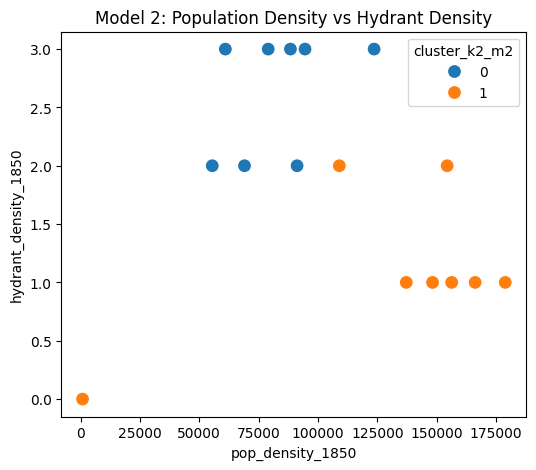

In [109]:
# Plot Scatterplot for Population Density vs Hydrant Density
plt.figure(figsize=(6,5))
sns.scatterplot(
    data=df_model2,
    x="pop_density_1850",
    y="hydrant_density_1850",
    hue="cluster_k2_m2",
    s=100
)

plt.title("Model 2: Population Density vs Hydrant Density")
plt.show()

Interpretation of Model 2 Population Density vs Hydrant Density scatterplot:

The plot shows that population density is still the main factor separating the clusters as seen in Model 1. High density wards mostly fall into one cluster, while lower density wards fall into the other.

Hydrant density does not clearly divide the groups. Both clusters contain wards with similar hydrant levels.

This suggests that even after adding hydrant infrastructure, population density remains the dominant structural feature shaping the clustering pattern.

## Cluster-Level Structural and Cholera Summary (K = 3)

In [113]:
# Create cluster-level summary for Model 2 (K = 3)
cluster_summary_m2_k3 = (
    df_model2
        .groupby("cluster_k3")[model2_vars + ["cholera_1849_rate_per_1000"]]
        .mean()
)

cluster_summary_m2_k3

,pop_density_1850,sewer_density_1847,hydrant_density_1850,cellar_exposure_rate_1850,cholera_1849_rate_per_1000
cluster_k3,,,,,
0,82774.335677,2.25,2.625000,0.031308,5.429465
1,149995.934143,1.00,1.285714,0.048028,14.530295
2,852.446982,0.00,0.000000,0.024591,14.926801


In [114]:
df_model2[["cluster_k3"]]

,cluster_k3
0,0
1,0
2,0
3,1
4,0
5,1
6,1
7,0
8,0
9,1


Interpretation of K = 3:

K = 3 produces a small cluster onyl including the 12th Ward driven by its lack of sewer and hydrant infrastructure.

If removing the 12th ward as an outlier, do other wards changed clusters?

In [115]:
# View ward membership by cluster (Model 2, K = 3) and cholera mortality decending
df_model2[["ward_id", "cluster_k3", "cholera_1849_rate_per_1000"]] \
    .sort_values("cholera_1849_rate_per_1000", ascending=False)

,ward_id,cluster_k3,cholera_1849_rate_per_1000
5,6,1,35.630415
3,4,1,28.989247
11,12,2,14.926801
1,2,0,13.072878
12,13,1,11.470651
2,3,0,7.822308
6,7,1,7.800551
4,5,0,7.273208
9,10,1,6.647796
13,14,1,6.191459


Interpretation of ward membership:

Model 2 with K = 3 isolates Ward 12 as a distinct outlier but does not substantially reorganize the remaining wards. The primary high mortality cluster remains intact, suggesting that the underlying structural divide is robust and best represented by K = 2.

# Model 1 and Model 2 K = 2 Comparison

**Comparing Silhouette Scores**

Model 1 K = 2 had a score of 0.438
Model 2 K = 2 had a score of 0.32

These values show that Model 1 had stronger structural separation, while Model 2 is more complex and less cleanly divided.

**Comparing Cluster Means**

Model 1:

Cluster 0:
* High populaiton density
* Lower sewer density
* Slightly higher cellar density
* Higher cholera rate = 12.05 per 1,000


Cluster 1:
* Lower population density
* Higher sewer density
* Slightly lower cellar density
* Lower cholera rate = 7.91 per 1,000

Model 2:

Cluster 0:

* Lower pop density
* higher sewer density
* higher hydrant density
* Lower cellar exposure
* Lower cholera rates = 5.43 per 1,000


Cluster 1:
* High population density
* Lower sewer density
* Lower hydrant density
* Higher cellar exposure
* Much higher cholera rate = 14.58 per 1,000

When adding hydrant density into the model and dropping N = 16, the high mortality cluster is still the group with high density, lower infrastructure.

**Comparing Ward Membership**

Model 1:

Cluster 0: High populaiton density, lower sewer density, higher cellar density, Higher cholera

Wards: 4th, 6th, 7th, 8th, 9th, 10th, 11th, 13th, 14th

Cluster 1: Lower population density, Higher sewer density, slightly lower cellar density, Lower cholera

Wards: 1st, 2nd, 3rd, 5th, 12th, 15th, 16th, 17th, 18th

Model 2:

Cluster 0: Lower pop density, higher sewer density, higher hydrant density, Lower cellar exposure, Lower cholera rate

Wards: 1st, 2nd, 3rd, 5th, 8th, 9th, 15th, 17th

Cluster 1: High population density, Lower sewer density, Lower hydrant density, Higher cellar exposure, Much higher cholera rate

Wards: 4th, 6th, 7th, 10th, 11th, 12th, 13th, 14th


Comparing ward membership across Model 1 and Model 2 reveals that the overall density driven structural divide remains intact, but inclusion of hydrant density reclassifies certain borderline wards. In Model 2, the 8th and 9th wards shift out of the high density, high mortality cluster, while the 12th ward moves into it.

This suggests that hydrant infrastructure refines structural similarity at the margins rather than overturning the broader density based typology. Population density continues to anchor the primary division between ward types, but water distribution intensity influences how specific wards are grouped within that structure.

**Summary Comparison: Model 1 vs Model 2 (K =2)**

Model 1 produced a strong two-cluster structure primarily driven by population density and sewer conditions. The high mortality wards were grouped together within a high density, lower infrastructure cluster.

Model 2 added hydrant density and excluded two wards with missing data, produced slightly weaker cluster separation. However, the overall structural pattern remained similar. The highest mortality wards continued to cluster together.

The main difference is that hydrant density reclassified a small number of wards at the margins, suggesting that water distribution infrastructure refines structural groupings but does not fundamentally reorganize the density driven typology observed in Model 1.